# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import optuna
from optuna.samplers import TPESampler
import warnings
import shap
warnings.filterwarnings("ignore")

# Read data

#### Feature Descriptions

1. person_age: Applicant’s age in years.

2. person_income: Annual income of the applicant in USD.

3. person_home_ownership: Status of homeownership (e.g., Rent, Own, Mortgage).

4. person_emp_length: Length of employment in years.

5. loan_intent: Purpose of the loan (e.g., Education, Medical, Personal).

6. loan_grade: Risk grade assigned to the loan, assessing the applicant’s creditworthiness.

7. loan_amnt: Total loan amount requested by the applicant.

8. loan_int_rate: Interest rate associated with the loan.

9. loan_percent_income: Percentage of the applicant’s income allocated towards loan repayment.

10. cb_person_default_on_file: Indicates if the applicant has a history of default ('Y' for yes, 'N' for no).

11. cb_person_cred_hist_length: Length of the applicant’s credit history in years.

12. loan_status: The approval status of the loan (approved or not approved).

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv', index_col='id')
original = pd.read_csv('/kaggle/input/ps4e9-original-data-loan-approval-prediction/credit_risk_dataset.csv')
train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.8+ MB


In [4]:
test = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv', index_col='id')
test.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
id,,,,,,,,,,,
58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39098 entries, 58645 to 97742
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  39098 non-null  int64  
 1   person_income               39098 non-null  int64  
 2   person_home_ownership       39098 non-null  object 
 3   person_emp_length           39098 non-null  float64
 4   loan_intent                 39098 non-null  object 
 5   loan_grade                  39098 non-null  object 
 6   loan_amnt                   39098 non-null  int64  
 7   loan_int_rate               39098 non-null  float64
 8   loan_percent_income         39098 non-null  float64
 9   cb_person_default_on_file   39098 non-null  object 
 10  cb_person_cred_hist_length  39098 non-null  int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 3.6+ MB


# EDA
#### Competition vs. Original
First, let's see if orignal and competiotion data differ in distribution.

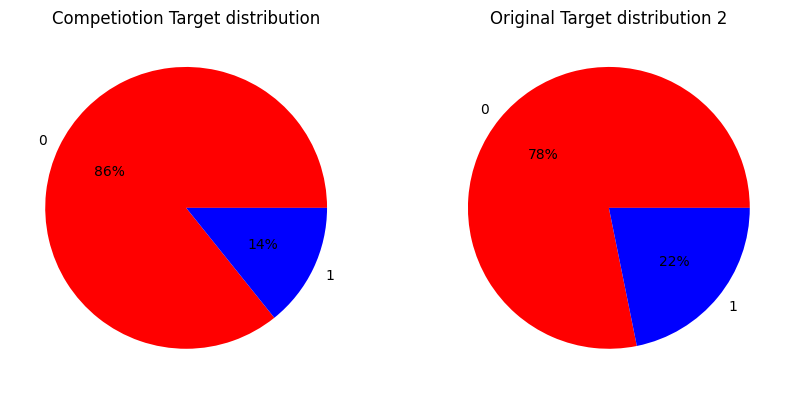

In [6]:
f, (ax1, ax2) = plt.subplots(1, 2)
f.set_figheight(8)
f.set_figwidth(10)

colors = ['red', 'blue']
ax1.pie(train.loan_status.value_counts(), labels=train.loan_status.value_counts().index, autopct="%.0f%%", colors=colors)
ax1.set_title('Competiotion Target distribution')

ax2.pie(original.loan_status.value_counts(), labels=original.loan_status.value_counts().index, autopct="%.0f%%", colors=colors)
ax2.set_title('Original Target distribution 2')

plt.show()

#### Adversarial validation

I take the code for adversarial validation from the Kaggle Book: https://github.com/PacktPublishing/The-Kaggle-Book/blob/main/chapter_06/adversarial-validation-example.ipynb

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict

X =  pd.concat([train, original], axis=0)
y = [0] * len(train) + [1] * len(original)

X['person_home_ownership'].replace({'RENT': 0, 'MORTGAGE': 1, 'OWN': 2, 'OTHER': 3}, inplace=True)
X['loan_intent'].replace({'EDUCATION': 0, 'MEDICAL': 1, 'PERSONAL': 2, 'VENTURE': 3, 'DEBTCONSOLIDATION': 4, 'HOMEIMPROVEMENT': 5}, inplace=True)
X['loan_grade'].replace({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}, inplace=True)
X['cb_person_default_on_file'].replace({'N': 0, 'Y': 1}, inplace=True)
X['person_emp_length'] = X['person_emp_length'].fillna(original['person_emp_length'].mean())
X['person_emp_length'] = X['person_emp_length'].astype(int)
X['loan_int_rate'] = X['loan_int_rate'].fillna(original['loan_int_rate'].mean())
X['loan_int_rate'] = (X['loan_int_rate'] * 100).astype(int)
X['loan_percent_income'] = (X['loan_percent_income'] * 100).astype(int)

model = RandomForestClassifier(random_state=0)
cv_preds = cross_val_predict(model, X, y, cv=5, n_jobs=-1, method='predict_proba')

score = roc_auc_score(y_true=y, y_score=cv_preds[:,1])
print(f"roc-auc score: {score:0.3f}")

roc-auc score: 0.353


Both Target distibution and adversarial validation (roc-auc not around ~0.5) show difference in distributions. Hence, it's doubtful, whether original data should be added.

#### Train, Test feature distribution comparison

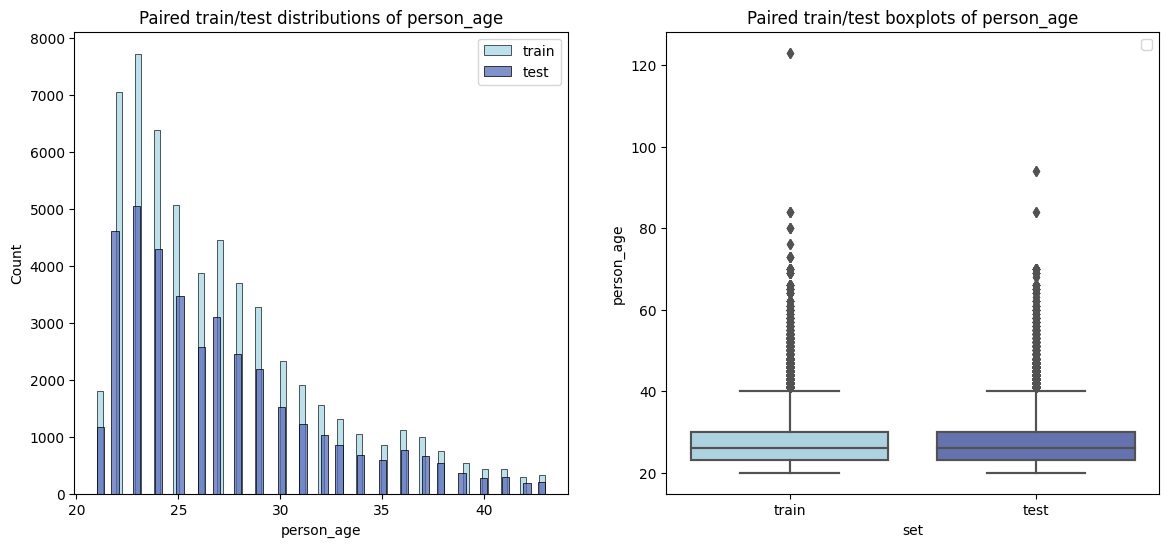

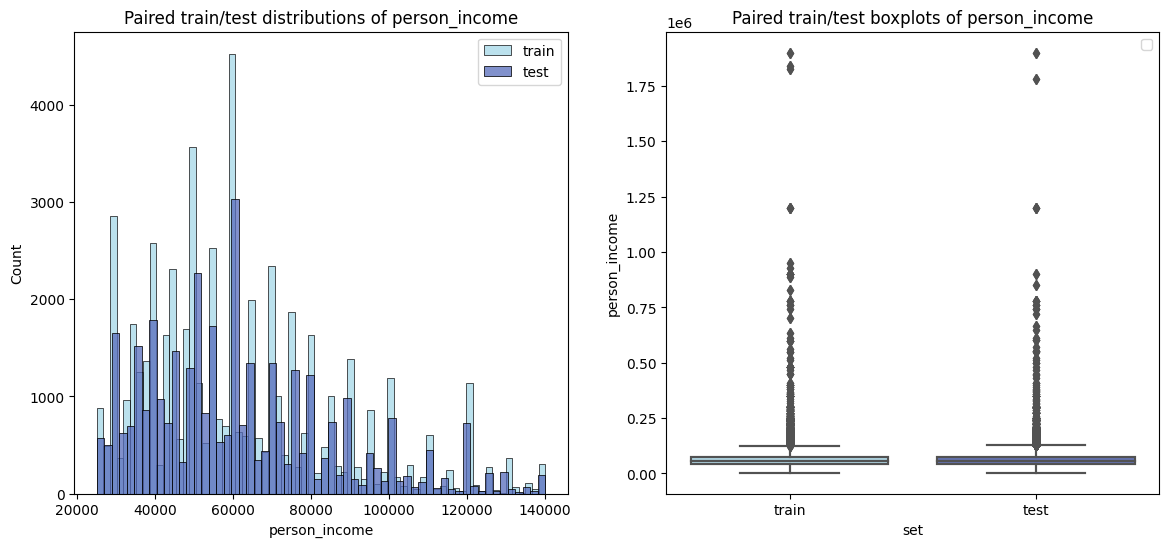

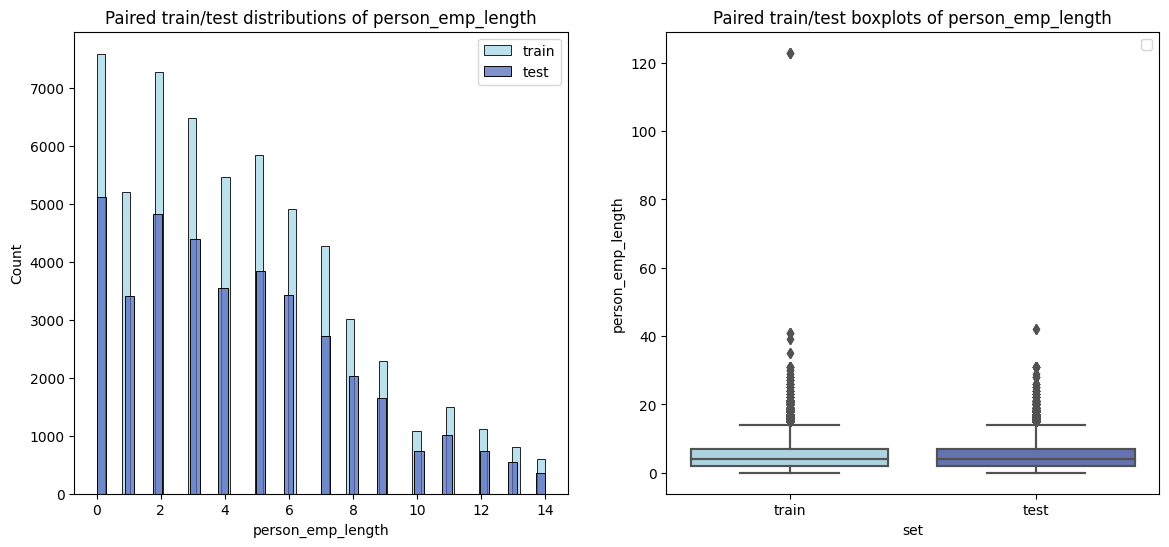

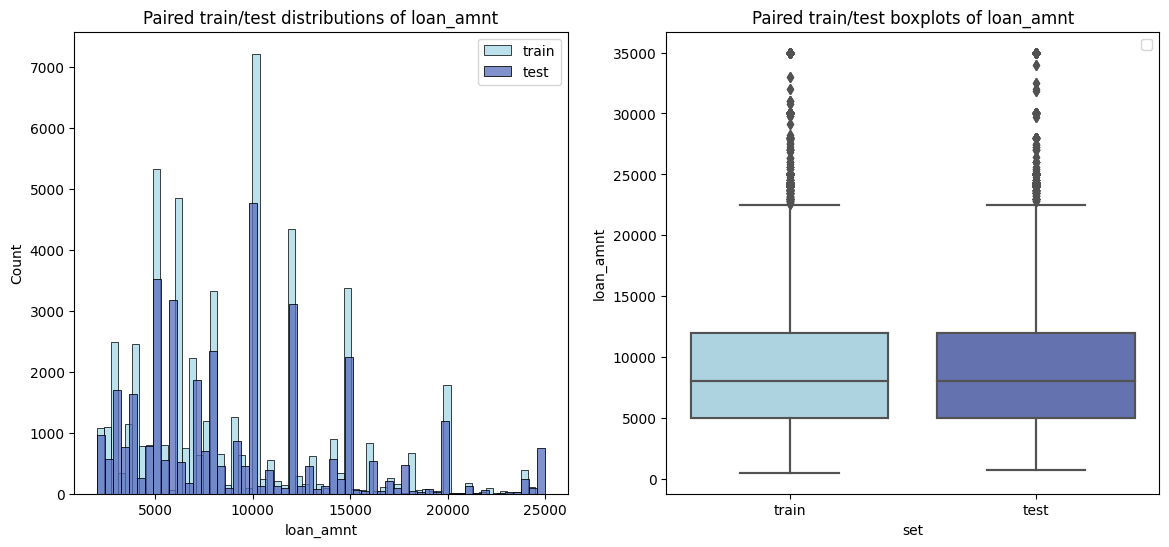

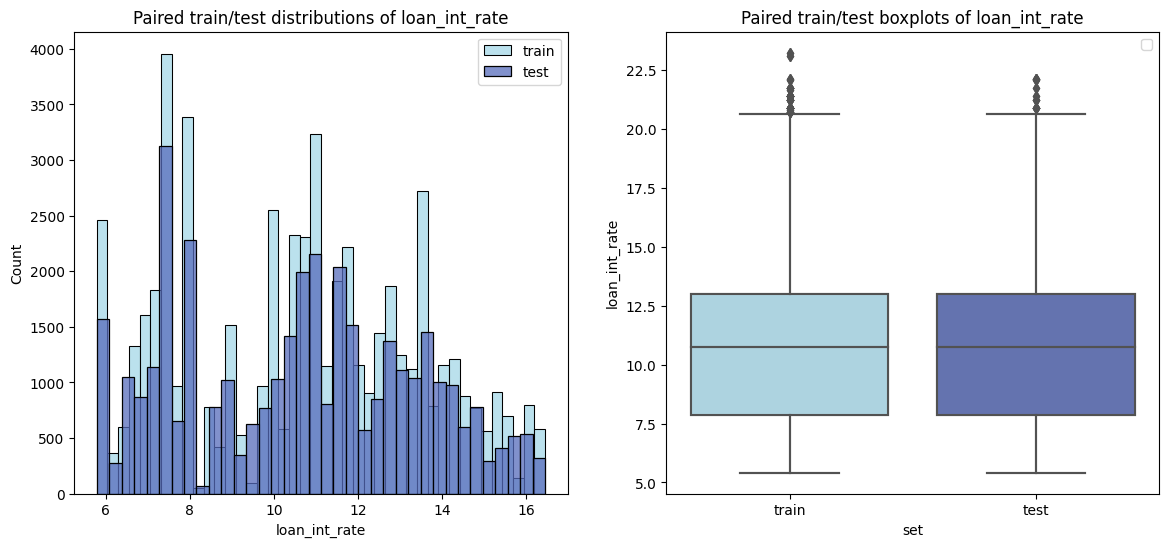

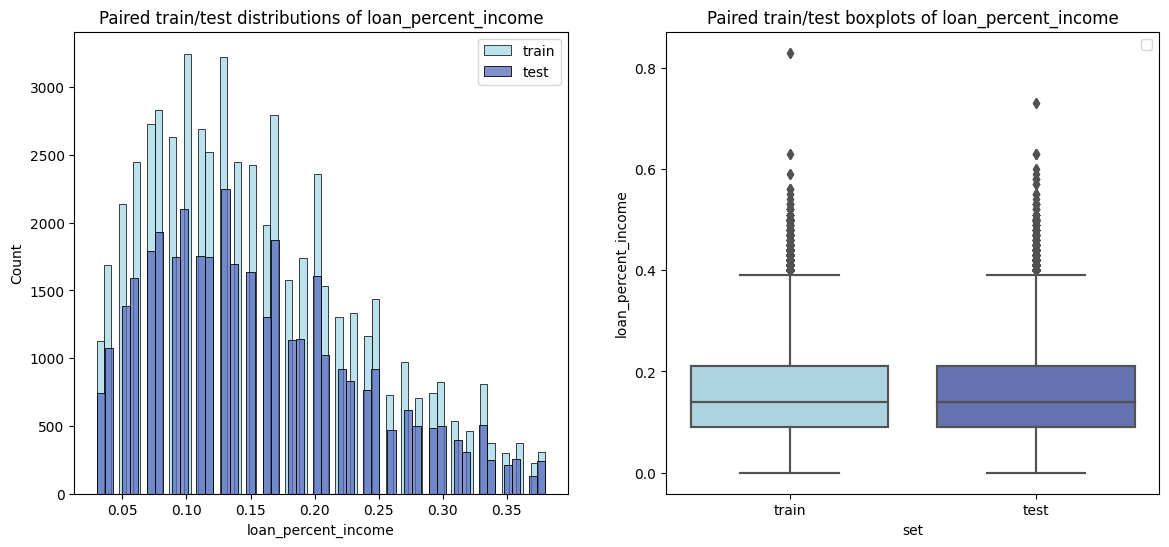

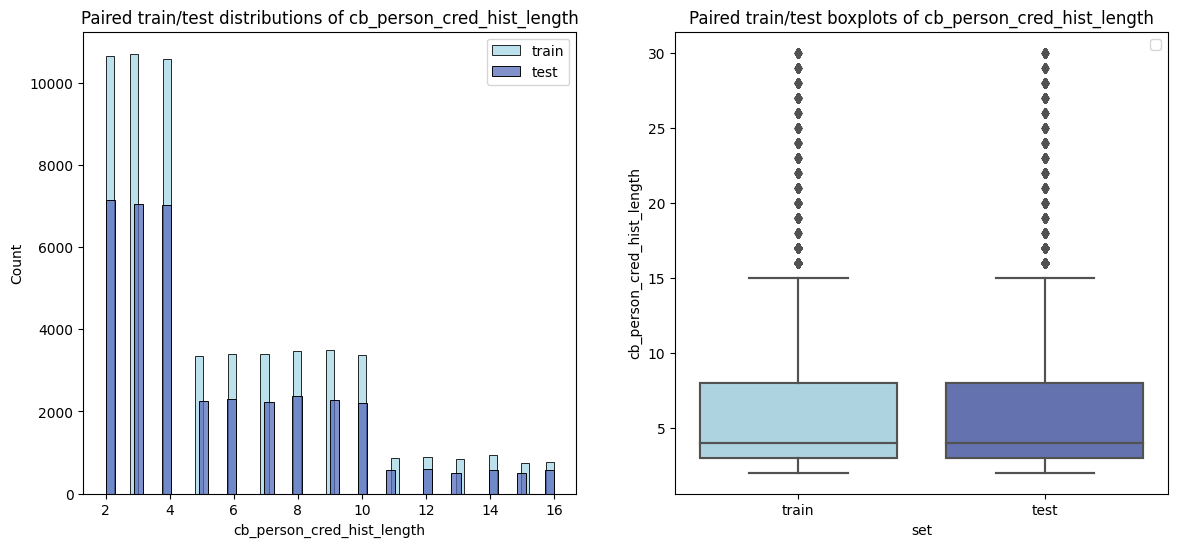

In [8]:
num_cols = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
def plot_distribution_pairs(train, test, feature, hue="set", palette=None):
    data_df = train.copy()
    data_df['set'] = 'train'
    data_df = pd.concat([data_df, test.copy()]).fillna('test')

    f, axes = plt.subplots(1, 2, figsize=(14, 6))
    for i, s in enumerate(data_df[hue].unique()):
        selection = data_df.loc[data_df[hue]==s, feature]
        # Filter 'selection' to include only the central 95% of the data
        q_025, q_975 = np.percentile(selection, [2.5, 97.5])
        selection_filtered = selection[(selection >= q_025) & (selection <= q_975)]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=FutureWarning)
            sns.histplot(selection_filtered, color=palette[i], ax=axes[0], label=s)
            sns.boxplot(x=hue, y=feature, data=data_df, palette=palette, ax=axes[1])
    axes[0].set_title(f"Paired train/test distributions of {feature}")
    axes[1].set_title(f"Paired train/test boxplots of {feature}")
    axes[0].legend()
    axes[1].legend()
    plt.show()

color_list = ["#A5D7E8", "#576CBC", "#19376D", "#0B2447"]
for feature in num_cols:
    plot_distribution_pairs(train, test, feature, palette=color_list)

In [9]:
X =  pd.concat([train.drop('loan_status', axis=1), test], axis=0)
y = [0] * len(train) + [1] * len(test)

X['person_home_ownership'].replace({'RENT': 0, 'MORTGAGE': 1, 'OWN': 2, 'OTHER': 3}, inplace=True)
X['loan_intent'].replace({'EDUCATION': 0, 'MEDICAL': 1, 'PERSONAL': 2, 'VENTURE': 3, 'DEBTCONSOLIDATION': 4, 'HOMEIMPROVEMENT': 5}, inplace=True)
X['loan_grade'].replace({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}, inplace=True)
X['cb_person_default_on_file'].replace({'N': 0, 'Y': 1}, inplace=True)
X['person_emp_length'] = X['person_emp_length'].astype(int)
X['loan_int_rate'] = (X['loan_int_rate'] * 100).astype(int)
X['loan_percent_income'] = (X['loan_percent_income'] * 100).astype(int)

model = RandomForestClassifier(random_state=0)
cv_preds = cross_val_predict(model, X, y, cv=5, n_jobs=-1, method='predict_proba')

score = roc_auc_score(y_true=y, y_score=cv_preds[:,1])
print(f"roc-auc score: {score:0.3f}")

roc-auc score: 0.500


Conclusion: train and test distributions are very close, which is proved both by visualisations and adversarial validation.

# Data preprocessing

In [10]:
X = pd.concat([train, original], ignore_index=True)
X = X.fillna('None')
def preprocess(df):
    df['loan_to_income'] = ((df['loan_amnt'] / df['person_income']) - df['loan_percent_income']).astype('string').astype('category')
    df['age_income_interaction'] = (df['person_age'] * df['person_income']).astype('string').astype('category')
    df['loan_to_emp_length_ratio'] = (df['loan_amnt'] / df['person_emp_length'].replace({'None': original['person_emp_length'].mean()}).astype('float')).astype('string').astype('category')
    monthly_income = df['person_income'] / 12
    df['monthly_debt'] = (df['loan_amnt'] * (1 + df['loan_int_rate'].replace({'None': original['loan_int_rate'].mean()})) / 12)
    df['dti_ratio'] = (df['monthly_debt'] / monthly_income).astype('string').astype('category')
    df['monthly_debt'] = df['monthly_debt'].astype('string').astype('category')
    df['risk_flag'] = (np.where((df['cb_person_default_on_file'] == 'Y') & (df['loan_grade'].isin(['C', 'D', 'E'])), 1, 0))
    df['risk_flag'] = df['risk_flag'].astype('category')
    df['person_home_ownership'] = df['person_home_ownership'].astype('category')
    df['loan_intent'] = df['loan_intent'].astype('category')
    df['loan_grade'] = df['loan_grade'].astype('category')
    df['cb_person_default_on_file'] = df['cb_person_default_on_file'].astype('category')
    df['person_emp_length'] = df['person_emp_length'].astype('string').astype('category')
    df['loan_int_rate'] = (df['loan_int_rate'] * 100).astype('string').astype('category')
    df['loan_percent_income'] = (df['loan_percent_income'] * 100).astype('string').astype('category')
    

preprocess(test)
preprocess(X)
y = X.pop('loan_status')
# y = df['loan_status']
# X = df.drop('loan_status', axis=1)

# Model

In [11]:
# Using optuna to tune hyperparameters a little bit
def objective(trial):
    params = {
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
    'iterations': 1000,
    'depth': trial.suggest_int('depth', 6, 12),
    'random_strength':0,
    'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-1, 1.0, log=True),
    'task_type':'GPU',
    'random_seed':42,
    'verbose':False
    }
    
    model = CatBoostClassifier(**params)
    cv = StratifiedKFold(5, shuffle=True, random_state=0)
    cv_splits = cv.split(X, y)
    scores = list()
    for train_idx, val_idx in cv_splits:
        X_train_fold, X_val_fold = X.loc[train_idx], X.loc[val_idx]
        y_train_fold, y_val_fold = y.loc[train_idx], y.loc[val_idx]
        X_train_pool = Pool(X_train_fold, y_train_fold, cat_features=X.columns.values)
        X_valid_pool = Pool(X_val_fold, y_val_fold, cat_features=X.columns.values)
        model.fit(X=X_train_pool, eval_set=X_valid_pool, verbose=False, early_stopping_rounds=200)
        val_pred = model.predict_proba(X_valid_pool)[:, 1]
        score = roc_auc_score(y_val_fold, val_pred)
        scores.append(score)  
    return np.mean(scores)

sqlite_db = "sqlite:///catboost.db"
study_name = "catboost"
optimize = False
if optimize:
    study = optuna.create_study(storage=sqlite_db, study_name=study_name, 
                                sampler=TPESampler(n_startup_trials=35, multivariate=True, seed=0),
                                direction="maximize", load_if_exists=True)

    study.optimize(objective, n_trials=100)
    print(f"best optimized roc-auc: {study.best_value:0.5f}") # 0.96664
    print(f"best hyperparameters: {study.best_params}") 
    catboost_params = study.best_params
else:
    catboost_params = {
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'learning_rate': 0.08114394459649094,
        'iterations': 1000,
        'depth': 6,
        'random_strength':0,
        'l2_leaf_reg': 0.7047064221215757,
        'task_type':'GPU',
        'random_seed':42,
        'verbose':False    
    }

The TPESampler is set to first try random optimization for the first 35 trials and then perform a TPE Bayesian Search. I also use the multivariate approach, which is reported to outperform the independent TPE.

In [12]:
cv = StratifiedKFold(5, shuffle=True, random_state=0)
cv_splits = cv.split(X, y)
scores = []
test_preds = []
X_test_pool = Pool(test, cat_features=X.columns.values)
for i, (train_idx, val_idx) in enumerate(cv_splits):
    model = CatBoostClassifier(**catboost_params)
    X_train_fold, X_val_fold = X.loc[train_idx], X.loc[val_idx]
    y_train_fold, y_val_fold = y.loc[train_idx], y.loc[val_idx]
    X_train_pool = Pool(X_train_fold, y_train_fold, cat_features=X.columns.values)
    X_valid_pool = Pool(X_val_fold, y_val_fold, cat_features=X.columns.values)
    model.fit(X=X_train_pool, eval_set=X_valid_pool, verbose=False, early_stopping_rounds=200)
    val_pred = model.predict_proba(X_valid_pool)[:, 1]
    score = roc_auc_score(y_val_fold, val_pred)
    scores.append(score)
    test_pred = model.predict_proba(X_test_pool)[:, 1]
    test_preds.append(test_pred)
    print(f'Fold {i + 1} roc_auc_score: {score}')
print(f'Cross-validated roc_auc_score: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')
print(f'Max roc_auc_score score: {np.max(scores):.3f}')
print(f'Min roc_auc_score score: {np.min(scores):.3f}')

Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 roc_auc_score: 0.9667162709507103


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 roc_auc_score: 0.9682588105372782


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 3 roc_auc_score: 0.9644369568942295


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 4 roc_auc_score: 0.9641254717192955


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 5 roc_auc_score: 0.9664601423394272
Cross-validated roc_auc_score: 0.966 +/- 0.002
Max roc_auc_score score: 0.968
Min roc_auc_score score: 0.964


# Explainability
To understand how the model actually works, the Catboost model itself is used to calculate SHAP (SHapley Additive exPlanations) values for each feature in the training data. The SHAP values are obtained by using **shap.TreeExplainer**. Then we create a summary plot visualizing the impact of different features on the model predictions and a violin plot, where each violin represents the distribution of SHAP values for a specific feature.

In [13]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_pool)

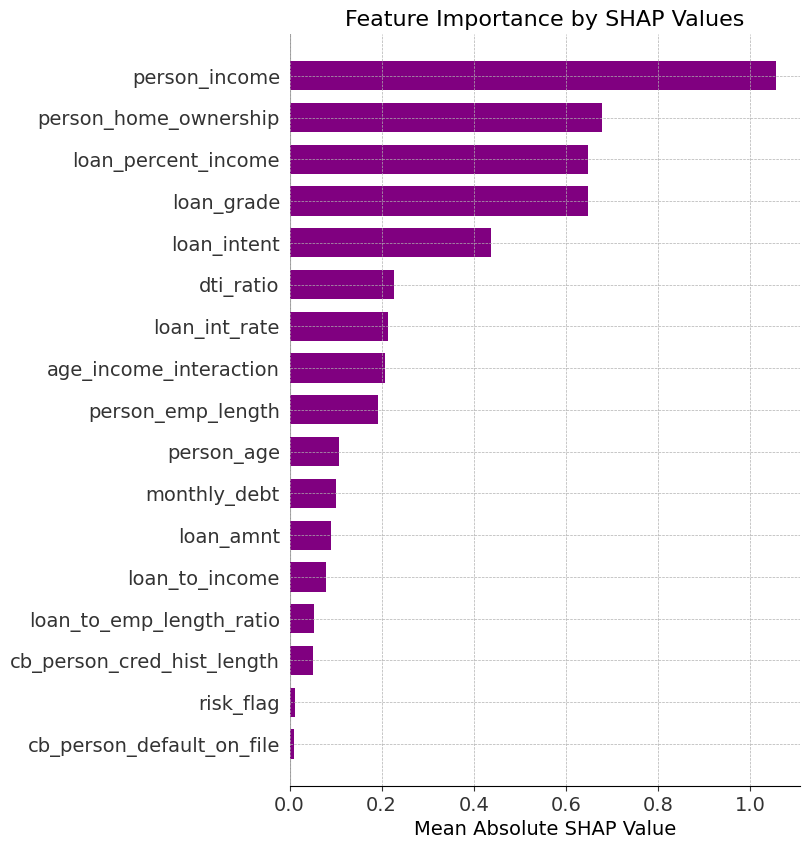

In [14]:
shap.summary_plot(
    shap_values, 
    X, 
    plot_type="bar", 
    class_names=np.unique(y),
    color='purple',
    show=False
)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  
plt.xlabel('Mean Absolute SHAP Value', fontsize=14) 
plt.title('Feature Importance by SHAP Values', fontsize=16) 
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5) 
plt.show()

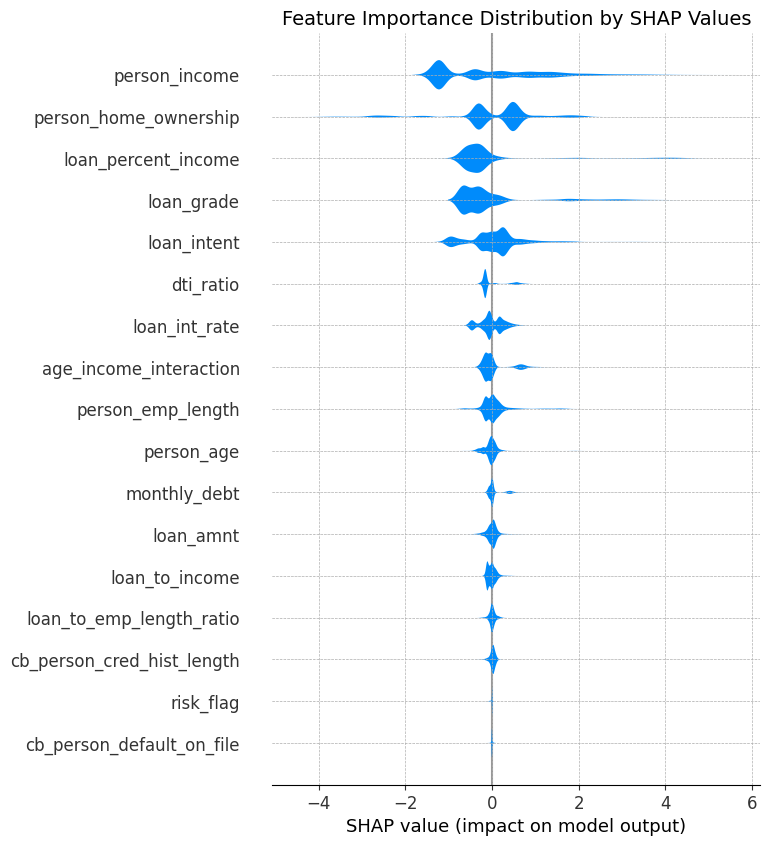

In [15]:
shap.summary_plot(shap_values, X.columns, plot_type="violin", show=False)
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12)  
plt.title('Feature Importance Distribution by SHAP Values', fontsize=14) 
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)  
plt.show()

# Submission

In [16]:
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e10/sample_submission.csv')
sample_submission['loan_status'] = np.mean(test_preds, axis=0)
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,id,loan_status
0,58645,0.999970
1,58646,0.017888
2,58647,0.530302
3,58648,0.006526
4,58649,0.035021
5,58650,0.944385
6,58651,0.000581
7,58652,0.004789
8,58653,0.317773
9,58654,0.005262
